In [1]:
import os 
import cv2 
import sys
import json  
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import albumentations as at 
import tensorflow_datasets as tfds 

In [2]:
from sklearn.model_selection import train_test_split 
from IPython.display import SVG 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop 
from tensorflow.keras.utils import to_categorical, Sequence, model_to_dot 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler 
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout, Concatenate 
from tensorflow.keras.layers import BatchNormalization 


In [3]:
DATA_DIR = "dataset/"

In [4]:
(train_ds, test_ds), info=tfds.load("eurosat/rgb", split=["train[:80%]", "train[:80%]"],
                                    shuffle_files=True,
                                    as_supervised=True,
                                    with_info = True,
                                    data_dir = DATA_DIR)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteMHFUDM/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [5]:
print(train_ds)
print(test_ds)
print(info)

<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    

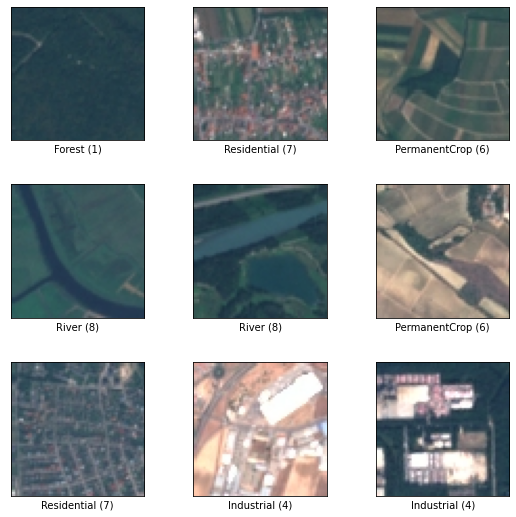

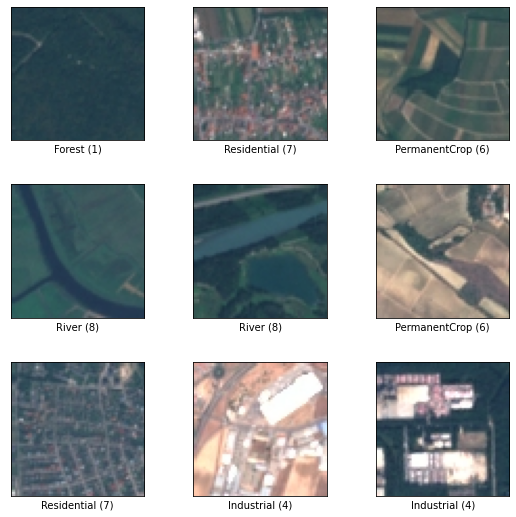

In [6]:
tfds.show_examples(train_ds, info)

,image,label
0,,1 (Forest)
1,,7 (Residential)
2,,6 (PermanentCrop)
3,,8 (River)
4,,8 (River)
5,,6 (PermanentCrop)
6,,7 (Residential)
7,,4 (Industrial)
8,,4 (Industrial)
9,,9 (SeaLake)

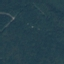
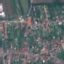
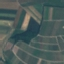
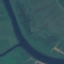
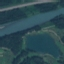
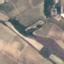
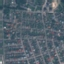
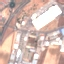
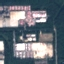
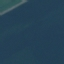

In [7]:
tfds.as_dataframe(test_ds.take(10), info)


In [8]:
NUM_CLASSES = info.features["label"].num_classes 
print(NUM_CLASSES)
print(info.features["label"].int2str(6))

10
PermanentCrop


In [9]:
BATCH_SIZE = 64 
BUFFER_SIZE = 1000 
IMAGE_SIZE = 64

In [10]:
def get_preprocessed_data(images, labels): 
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels 


In [11]:
train_data = train_ds.map(get_preprocessed_data, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_ds.map(get_preprocessed_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [12]:
def build_model():

    model = Sequential([

        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),

        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'), 
        Dropout(0.3),  
        Dense(64, activation='relu'), 
        Dropout(0.3),              
        Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [13]:
model = build_model()

In [15]:
model.compile(optimizer=Adam(lr=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_data, 
                    validation_data = test_data, 
                    epochs=50)
model.save("./ex05.h5")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
338/338 [==============================] - 24s 33ms/step - loss: 1.5755 - accuracy: 0.4537 - val_loss: 1.6033 - val_accuracy: 0.4520
Epoch 2/50
338/338 [==============================] - 7s 21ms/step - loss: 1.1301 - accuracy: 0.6110 - val_loss: 0.8197 - val_accuracy: 0.7006
Epoch 3/50
338/338 [==============================] - 8s 22ms/step - loss: 0.9523 - accuracy: 0.6749 - val_loss: 0.6744 - val_accuracy: 0.7771
Epoch 4/50
338/338 [==============================] - 8s 22ms/step - loss: 0.8284 - accuracy: 0.7133 - val_loss: 0.5443 - val_accuracy: 0.8166
Epoch 5/50
338/338 [==============================] - 8s 22ms/step - loss: 0.7487 - accuracy: 0.7506 - val_loss: 0.4998 - val_accuracy: 0.8501
Epoch 6/50
338/338 [==============================] - 7s 21ms/step - loss: 0.6728 - accuracy: 0.7731 - val_loss: 0.4421 - val_accuracy: 0.8510
Epoch 7/50
338/338 [==============================] - 7s 21ms/step - loss: 0.6217 - accuracy: 0.7919 - val_loss: 0.4231 - val_accuracy: 0.869

In [16]:
def get_show_plot_loss_acc(history, epoch):
    loss, val_loss = history.history["loss"], history.history["val_loss"]
    acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch+1), loss, label="Training")
    axes[0].plot(range(1, epoch+1), val_loss, label="validation")
    axes[0].legend(loc="best")
    axes[0].set_title("Loss")

    axes[1].plot(range(1, epoch+1), acc, label="Training")
    axes[1].plot(range(1, epoch+1), val_acc, label="Validation")
    axes[1].legend(loc="best")
    axes[1].set_title("Accuracy")

    plt.show()



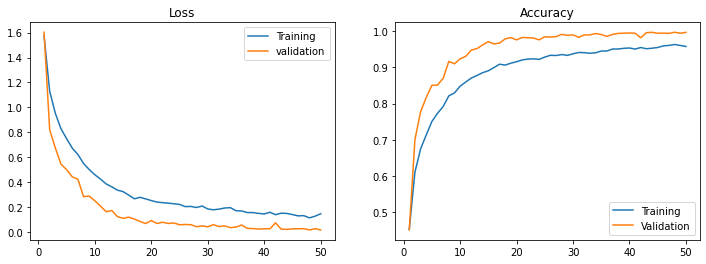

In [17]:
get_show_plot_loss_acc(history, 50)